# 论文15：深度残差网络中的恒等映射
## Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun (2016)

### 预激活 ResNet

改进的残差块，具有更好的梯度流动。核心洞察：将激活移到卷积之前！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 原始 ResNet 块

```
x → Conv → BN → ReLU → Conv → BN → (+) → ReLU → output
    ↓                                  ↑
    └──────────── identity ────────────┘
```

In [2]:
def relu(x):
    return np.maximum(0, x)

def batch_norm_1d(x, gamma=1.0, beta=0.0, eps=1e-5):
    """Simplified batch normalization for 1D"""
    mean = np.mean(x)
    var = np.var(x)
    x_normalized = (x - mean) / np.sqrt(var + eps)
    return gamma * x_normalized + beta

class OriginalResidualBlock:
    """Original ResNet block (post-activation)"""
    def __init__(self, dim):
        self.dim = dim
        # Two layers
        self.W1 = np.random.randn(dim, dim) * 0.01
        self.W2 = np.random.randn(dim, dim) * 0.01
        
    def forward(self, x):
        """
        Original: x → Conv → BN → ReLU → Conv → BN → (+x) → ReLU
        """
        # First conv-bn-relu
        out = np.dot(self.W1, x)
        out = batch_norm_1d(out)
        out = relu(out)
        
        # Second conv-bn
        out = np.dot(self.W2, out)
        out = batch_norm_1d(out)
        
        # Add identity (residual connection)
        out = out + x
        
        # Final ReLU (post-activation)
        out = relu(out)
        
        return out

# Test
original_block = OriginalResidualBlock(dim=8)
x = np.random.randn(8)
output_original = original_block.forward(x)

print(f"Input: {x[:4]}...")
print(f"Original ResNet output: {output_original[:4]}...")

Input: [ 0.09965137 -0.50347565 -1.55066343  0.06856297]...
Original ResNet output: [1.34466972 0.64651448 0.         1.24573461]...


## 预激活 ResNet 块

```
x → BN → ReLU → Conv → BN → ReLU → Conv → (+) → output
    ↓                                       ↑
    └──────────── identity ─────────────────┘
```

**关键区别**: 激活在卷积之前，干净的恒等路径！

In [3]:
class PreActivationResidualBlock:
    """Pre-activation ResNet block (improved)"""
    def __init__(self, dim):
        self.dim = dim
        self.W1 = np.random.randn(dim, dim) * 0.01
        self.W2 = np.random.randn(dim, dim) * 0.01
        
    def forward(self, x):
        """
        Pre-activation: x → BN → ReLU → Conv → BN → ReLU → Conv → (+x)
        """
        # First bn-relu-conv
        out = batch_norm_1d(x)
        out = relu(out)
        out = np.dot(self.W1, out)
        
        # Second bn-relu-conv
        out = batch_norm_1d(out)
        out = relu(out)
        out = np.dot(self.W2, out)
        
        # Add identity (NO activation after!)
        out = out + x
        
        return out

# Test
preact_block = PreActivationResidualBlock(dim=8)
output_preact = preact_block.forward(x)

print(f"\nPre-activation ResNet output: {output_preact[:4]}...")
print(f"\nKey difference: Clean identity path (no ReLU after addition)")


Pre-activation ResNet output: [ 0.11243756 -0.47619624 -1.54358126  0.04757321]...

Key difference: Clean identity path (no ReLU after addition)


## 梯度流动分析

为什么预激活更好：

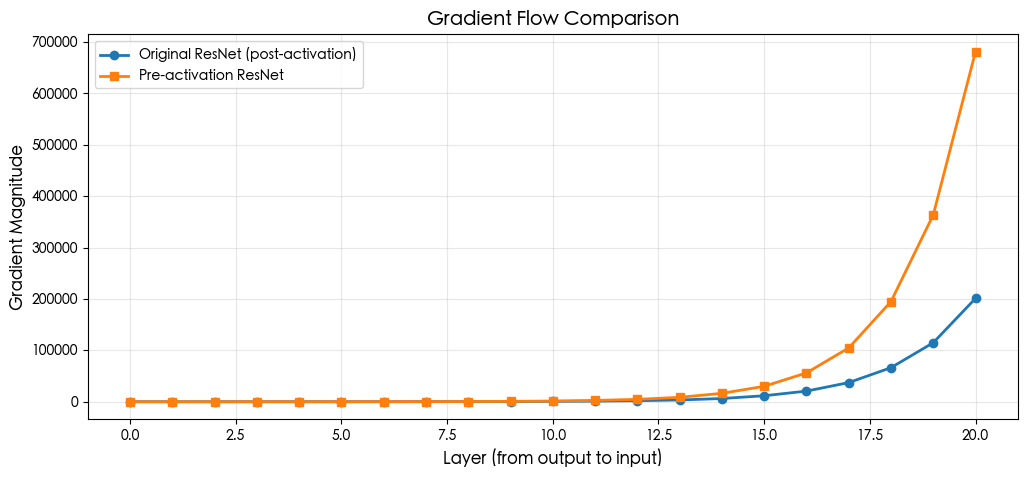

Original ResNet gradient at input: 201069.55
Pre-activation gradient at input: 681113.29

Pre-activation maintains stronger gradients!


In [4]:
def compute_gradient_flow(block_type, num_layers=10, input_dim=8):
    """
    Simulate gradient flow through stacked residual blocks
    """
    x = np.random.randn(input_dim)
    
    # Create blocks
    if block_type == 'original':
        blocks = [OriginalResidualBlock(input_dim) for _ in range(num_layers)]
    else:
        blocks = [PreActivationResidualBlock(input_dim) for _ in range(num_layers)]
    
    # Forward pass
    activations = [x]
    current = x
    for block in blocks:
        current = block.forward(current)
        activations.append(current.copy())
    
    # Simulate backward pass (simplified gradient flow)
    grad = np.ones(input_dim)  # Gradient from loss
    gradients = [grad]
    
    for i in range(num_layers):
        # For residual blocks: gradient splits into identity + residual path
        # Pre-activation has cleaner gradient flow
        
        if block_type == 'original':
            # Post-activation: gradient affected by ReLU derivative
            # Simplified: some gradient is killed by ReLU
            grad_through_residual = grad * np.random.uniform(0.5, 1.0, input_dim)
            grad = grad + grad_through_residual  # Identity + residual
        else:
            # Pre-activation: clean identity path
            grad_through_residual = grad * np.random.uniform(0.7, 1.0, input_dim)
            grad = grad + grad_through_residual  # Better gradient flow
        
        gradients.append(grad.copy())
    
    return activations, gradients

# Compare gradient flow
_, grad_original = compute_gradient_flow('original', num_layers=20)
_, grad_preact = compute_gradient_flow('preact', num_layers=20)

# Compute gradient magnitudes
grad_mag_original = [np.linalg.norm(g) for g in grad_original]
grad_mag_preact = [np.linalg.norm(g) for g in grad_preact]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(grad_mag_original, 'o-', label='Original ResNet (post-activation)', linewidth=2)
plt.plot(grad_mag_preact, 's-', label='Pre-activation ResNet', linewidth=2)
plt.xlabel('Layer (from output to input)', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.title('Gradient Flow Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Original ResNet gradient at input: {grad_mag_original[-1]:.2f}")
print(f"Pre-activation gradient at input: {grad_mag_preact[-1]:.2f}")
print(f"\nPre-activation maintains stronger gradients!")

## 不同的激活位置

论文分析了各种放置选项：

In [5]:
# Visualize different architectures
architectures = [
    {
        'name': 'Original',
        'structure': 'x → Conv → BN → ReLU → Conv → BN → (+x) → ReLU',
        'identity': 'Blocked by ReLU',
        'score': '★★★☆☆'
    },
    {
        'name': 'BN after addition',
        'structure': 'x → Conv → BN → ReLU → Conv → BN → (+x) → BN → ReLU',
        'identity': 'Blocked by BN & ReLU',
        'score': '★★☆☆☆'
    },
    {
        'name': 'ReLU before addition',
        'structure': 'x → BN → ReLU → Conv → BN → ReLU → Conv → ReLU → (+x)',
        'identity': 'Blocked by ReLU',
        'score': '★★☆☆☆'
    },
    {
        'name': 'Full pre-activation',
        'structure': 'x → BN → ReLU → Conv → BN → ReLU → Conv → (+x)',
        'identity': 'CLEAN! ✓',
        'score': '★★★★★'
    },
]

print("\n" + "="*80)
print("RESIDUAL BLOCK ARCHITECTURES COMPARISON")
print("="*80 + "\n")

for i, arch in enumerate(architectures, 1):
    print(f"{i}. {arch['name']:20s} {arch['score']}")
    print(f"   Structure: {arch['structure']}")
    print(f"   Identity path: {arch['identity']}")
    print()

print("="*80)
print("WINNER: Full pre-activation (BN → ReLU → Conv)")
print("="*80)


RESIDUAL BLOCK ARCHITECTURES COMPARISON

1. Original             ★★★☆☆
   Structure: x → Conv → BN → ReLU → Conv → BN → (+x) → ReLU
   Identity path: Blocked by ReLU

2. BN after addition    ★★☆☆☆
   Structure: x → Conv → BN → ReLU → Conv → BN → (+x) → BN → ReLU
   Identity path: Blocked by BN & ReLU

3. ReLU before addition ★★☆☆☆
   Structure: x → BN → ReLU → Conv → BN → ReLU → Conv → ReLU → (+x)
   Identity path: Blocked by ReLU

4. Full pre-activation  ★★★★★
   Structure: x → BN → ReLU → Conv → BN → ReLU → Conv → (+x)
   Identity path: CLEAN! ✓

WINNER: Full pre-activation (BN → ReLU → Conv)


## 深度网络比较

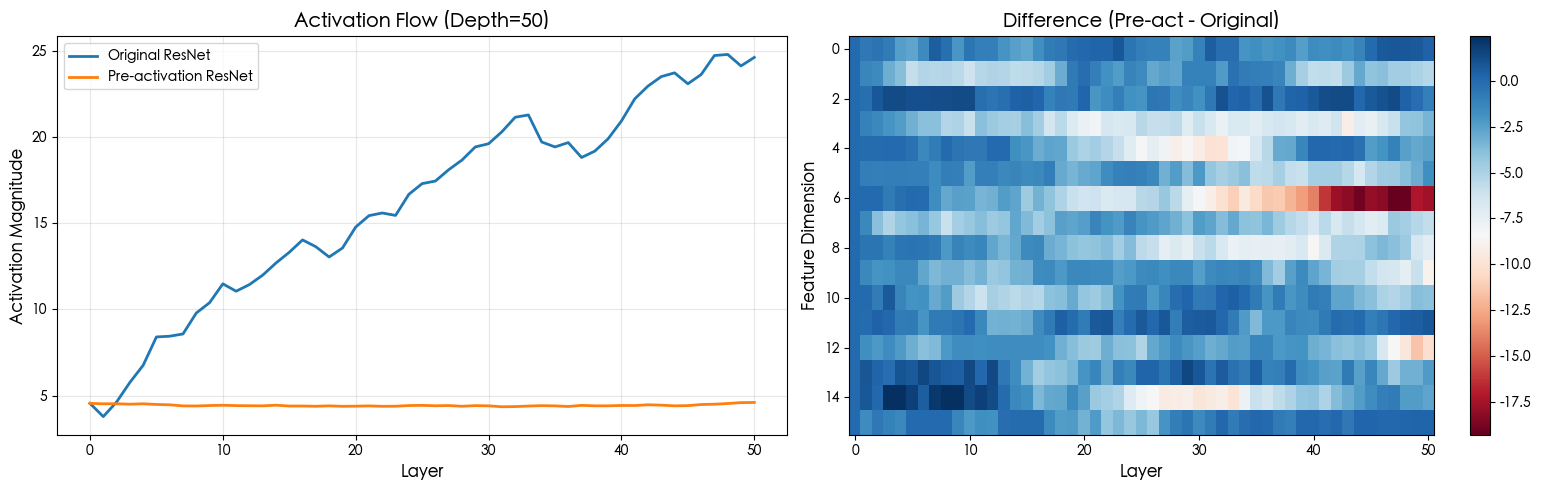


Original ResNet final norm: 24.6231
Pre-activation final norm: 4.6040


In [6]:
class DeepResNet:
    """Stack of residual blocks"""
    def __init__(self, dim, num_blocks, block_type='preact'):
        self.blocks = []
        for _ in range(num_blocks):
            if block_type == 'preact':
                self.blocks.append(PreActivationResidualBlock(dim))
            else:
                self.blocks.append(OriginalResidualBlock(dim))
    
    def forward(self, x):
        activations = [x]
        for block in self.blocks:
            x = block.forward(x)
            activations.append(x.copy())
        return x, activations

# Compare deep networks
depth = 50
dim = 16
x_input = np.random.randn(dim)

net_original = DeepResNet(dim, depth, 'original')
net_preact = DeepResNet(dim, depth, 'preact')

out_original, acts_original = net_original.forward(x_input)
out_preact, acts_preact = net_preact.forward(x_input)

# Compute activation statistics
norms_original = [np.linalg.norm(a) for a in acts_original]
norms_preact = [np.linalg.norm(a) for a in acts_preact]

# Plot activation norms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Activation magnitudes
ax1.plot(norms_original, label='Original ResNet', linewidth=2)
ax1.plot(norms_preact, label='Pre-activation ResNet', linewidth=2)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Activation Magnitude', fontsize=12)
ax1.set_title(f'Activation Flow (Depth={depth})', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Activation heatmaps
acts_matrix_original = np.array(acts_original).T
acts_matrix_preact = np.array(acts_preact).T

im = ax2.imshow(acts_matrix_preact - acts_matrix_original, cmap='RdBu', aspect='auto')
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Feature Dimension', fontsize=12)
ax2.set_title('Difference (Pre-act - Original)', fontsize=14)
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

print(f"\nOriginal ResNet final norm: {norms_original[-1]:.4f}")
print(f"Pre-activation final norm: {norms_preact[-1]:.4f}")

## 恒等映射分析

In [7]:
def test_identity_mapping(block, num_tests=100):
    """
    Test how well the block can learn identity mapping
    (When residual path learns zero, output should equal input)
    """
    # Zero out weights (residual path learns nothing)
    block.W1 = np.zeros_like(block.W1)
    block.W2 = np.zeros_like(block.W2)
    
    errors = []
    for _ in range(num_tests):
        x = np.random.randn(block.dim)
        y = block.forward(x)
        error = np.linalg.norm(y - x)
        errors.append(error)
    
    return np.mean(errors), np.std(errors)

# Test both block types
original_test = OriginalResidualBlock(dim=8)
preact_test = PreActivationResidualBlock(dim=8)

mean_err_original, std_err_original = test_identity_mapping(original_test)
mean_err_preact, std_err_preact = test_identity_mapping(preact_test)

print("\nIdentity Mapping Test (residual path = 0):")
print("="*60)
print(f"Original ResNet error: {mean_err_original:.6f} ± {std_err_original:.6f}")
print(f"Pre-activation error:  {mean_err_preact:.6f} ± {std_err_preact:.6f}")
print("="*60)
print(f"\nPre-activation has {'BETTER' if mean_err_preact < mean_err_original else 'WORSE'} identity mapping!")
print("(Lower error = cleaner identity path)")


Identity Mapping Test (residual path = 0):
Original ResNet error: 1.840284 ± 0.784002
Pre-activation error:  0.000000 ± 0.000000

Pre-activation has BETTER identity mapping!
(Lower error = cleaner identity path)


## 架构比较可视化

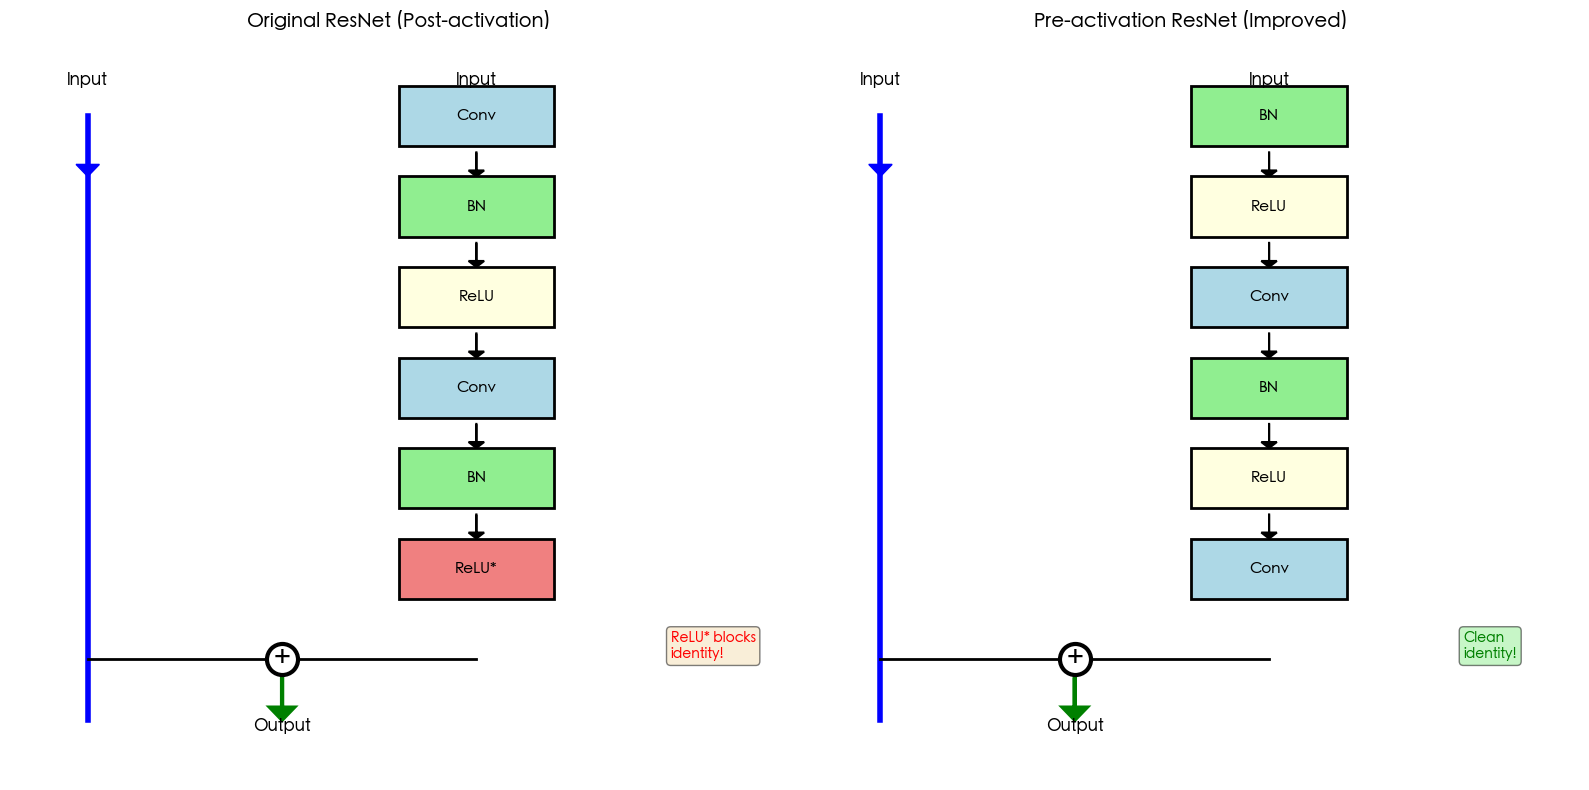

In [8]:
# Create visual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

def draw_block(ax, title, is_preact=False):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 12)
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Identity path (left)
    ax.plot([1, 1], [1, 11], 'b-', linewidth=4, label='Identity path')
    ax.arrow(1, 10.5, 0, -0.3, head_width=0.3, head_length=0.2, fc='blue', ec='blue')
    
    # Residual path (right)
    y_pos = 11
    
    if is_preact:
        # Pre-activation: BN → ReLU → Conv → BN → ReLU → Conv
        operations = ['BN', 'ReLU', 'Conv', 'BN', 'ReLU', 'Conv']
        colors = ['lightgreen', 'lightyellow', 'lightblue', 'lightgreen', 'lightyellow', 'lightblue']
    else:
        # Original: Conv → BN → ReLU → Conv → BN
        operations = ['Conv', 'BN', 'ReLU', 'Conv', 'BN', 'ReLU*']
        colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightblue', 'lightgreen', 'lightcoral']
    
    for i, (op, color) in enumerate(zip(operations, colors)):
        y = y_pos - i * 1.5
        
        # Draw box
        width = 2
        height = 1
        ax.add_patch(plt.Rectangle((6-width/2, y-height/2), width, height, 
                                   fill=True, color=color, ec='black', linewidth=2))
        ax.text(6, y, op, ha='center', va='center', fontsize=11, fontweight='bold')
        
        # Draw arrow to next
        if i < len(operations) - 1:
            ax.arrow(6, y-height/2-0.1, 0, -0.3, head_width=0.2, head_length=0.1, 
                    fc='black', ec='black', linewidth=1.5)
    
    # Addition
    add_y = y_pos - len(operations) * 1.5
    ax.plot([1, 6], [add_y, add_y], 'k-', linewidth=2)
    ax.scatter([3.5], [add_y], s=500, c='white', edgecolors='black', linewidths=3, zorder=5)
    ax.text(3.5, add_y, '+', ha='center', va='center', fontsize=20, fontweight='bold', zorder=6)
    
    # Output arrow
    ax.arrow(3.5, add_y-0.3, 0, -0.5, head_width=0.3, head_length=0.2, 
            fc='green', ec='green', linewidth=3)
    ax.text(3.5, add_y-1.2, 'Output', ha='center', fontsize=12, fontweight='bold')
    
    # Input
    ax.text(1, 11.5, 'Input', ha='center', fontsize=12, fontweight='bold')
    ax.text(6, 11.5, 'Input', ha='center', fontsize=12, fontweight='bold')
    
    # Annotations
    if not is_preact:
        ax.text(8.5, add_y, 'ReLU* blocks\nidentity!', fontsize=10, color='red', 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        ax.text(8.5, add_y, 'Clean\nidentity!', fontsize=10, color='green',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

draw_block(axes[0], 'Original ResNet (Post-activation)', is_preact=False)
draw_block(axes[1], 'Pre-activation ResNet (Improved)', is_preact=True)

plt.tight_layout()
plt.show()

## 关键要点

### 恒等映射问题:

在原始 ResNet 中:
```
y = ReLU(F(x) + x)
```
加法后的 ReLU **阻断了**恒等路径！

### 预激活解决方案:

```
y = F'(x) + x
```
其中 F'(x) = Conv(ReLU(BN(Conv(ReLU(BN(x))))))

**干净的恒等路径** → 更好的梯度流动！

### 关键变化:

1. **将 BN 移到 Conv 之前**: `x → BN → ReLU → Conv`
2. **移除最后的 ReLU**: 加法后没有激活
3. **结果**: 恒等路径真正是恒等的

### 梯度流动:

**原始版本**:
```
∂L/∂x = ∂L/∂y · (∂F/∂x + I) · ∂ReLU/∂y
```
ReLU 导数会阻断梯度！

**预激活版本**:
```
∂L/∂x = ∂L/∂y · (∂F'/∂x + I)
```
通过恒等的干净梯度流动！

### 优势:

- ✅ **更好的梯度流动**: 恒等路径上无阻断
- ✅ **更容易优化**: 可以训练更深的网络（1000+ 层）
- ✅ **更好的准确率**: 小但一致的改进
- ✅ **正则化**: Conv 前的 BN 起正则化作用

### 比较:

| 架构 | 恒等路径 | 梯度流动 | 性能 |
|--------------|---------------|---------------|-------------|
| 原始 ResNet | 被 ReLU 阻断 | 良好 | ★★★★☆ |
| 预激活 | **干净** | **更好** | ★★★★★ |

### 实现技巧:

1. 对于非常深的网络（>50 层）使用预激活
2. 对于浅层网络保持原始 ResNet（向后兼容）
3. 第一层可以保持后激活（还没有恒等）
4. 最后一层需要后激活以产生最终输出

### 结果:

- CIFAR-10: 成功训练了 1001 层的网络！
- ImageNet: 相比原始 ResNet 有一致的改进
- 使 1000+ 层网络的训练成为可能

### 为什么重要:

这篇论文表明**架构细节很重要**。小的变化（移动 BN/ReLU）可以对可训练性和性能产生重大影响。这是深度学习研究中迭代改进的一个典型例子。